# pyPSFstack use example

In [101]:

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from pyPSFstack.pupils.sources import DipoleInterfaceSource
from pyPSFstack.pupils.windows import SEO
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
from pyPSFstack.diversities.pola_diversities import PDiversity_QWP, \
    PDiversity_LP, PDiversity_Compound
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring import ExactBlurring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Modelling a PSF stack with a SEO Fourier window followed by a QWP and Wollaston prism 

## 1. Setting the source and Fourier window

Let us begin by specifying the experimental parameters:

In [6]:
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
distance_coverslip = 10
wavelength = 525

These parameters, in turn, fix the pupil properties:

In [7]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = 256

Then we define the pupil sequence that we want to model. In general this will be composed by a source and a window at the Fourier plane. 

In [8]:
params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = distance_coverslip/wavelength

params['window'] = {}
params['window']['c'] = np.pi#1.24*np.pi

In [11]:
src = DipoleInterfaceSource(**params['pupil'],**params['source'])
wdw = SEO(**params['pupil'],**params['window'])
pupil_sequence = [src, wdw]

We can plot the source and window

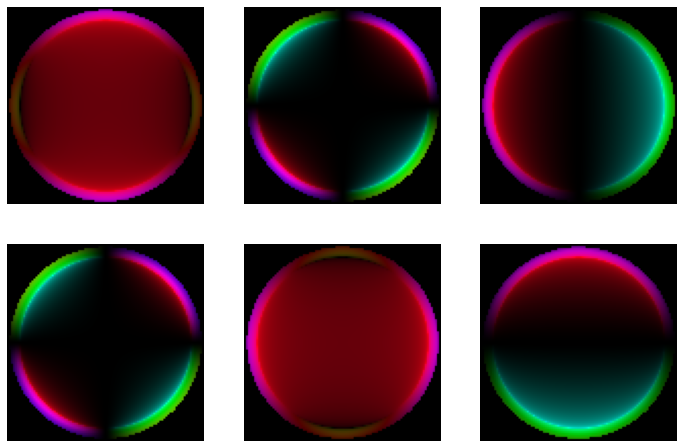

In [12]:
src.plot_pupil_field()

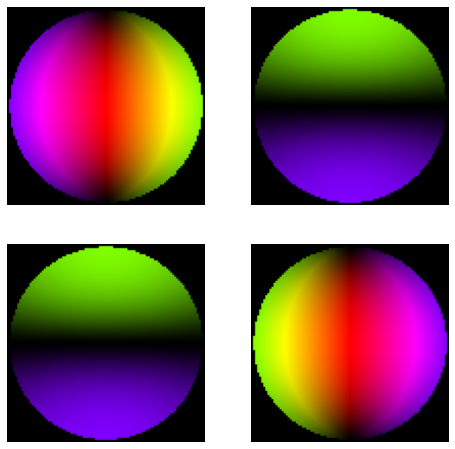

In [13]:
wdw.plot_pupil_field()

## 2. Defining the pupil and polarization diversities

Then we define the phase and polarization diversities:

In [14]:
params['zdiversity'] = {}
zi = -300; zf = 300; z_step = 100
params['zdiversity']['z_list'] = np.arange(zi,zf+z_step,z_step) / wavelength
params['zdiversity']['nf'] = nf

zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])

The polarization splitting can be modelled by a polarization diversity

In [15]:
qwp = PDiversity_QWP([np.pi/4])
wollaston = PDiversity_LP([0, np.pi/2])
pdiv = PDiversity_Compound([qwp, wollaston])

In [113]:
params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = distance_coverslip/wavelength
params['blurring']['diff_del_list'] = np.linspace(-params['blurring']['radius'],
    params['blurring']['radius'],8)[1:-1]

In [124]:
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

## 3. Computing the PSF stack

Finally, we initialize an instance of the class `PSFStack` which allows us to compute the desired PSF stack and even model the effect of background, photobleaching and noise:

In [145]:
psfs = PSFStack(pupil_sequence, zdiversity=zdiv, pdiversity=pdiv)
psfs.compute_psf_stack(orientation=[0,0,0])

In [147]:
psfs_blurred = PSFStack(pupil_sequence, zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs_blurred.compute_psf_stack(orientation=[0,0,0])

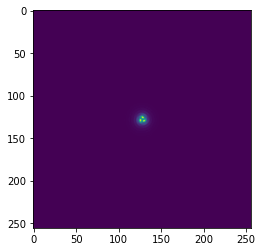

In [137]:
plt.imshow(np.abs(np.fft.fftshift(psfs_blurred.psf_stack[:,:,0,0], axes=(0,1))))

Let us visualize the result:

In [141]:
stack.shape

(30, 30, 7, 2)

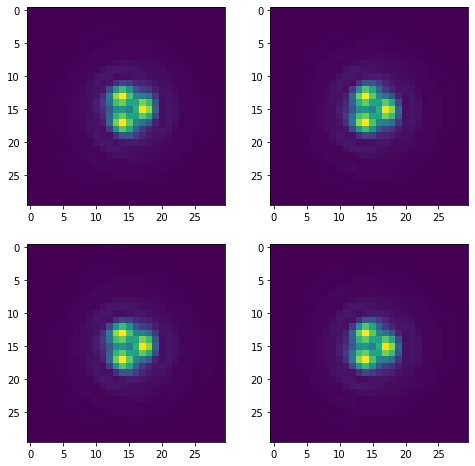

In [148]:
zdiv_mid_ind = int((zf-zi)/z_step//2)
stack = trim_stack(psfs.psf_stack, 30)
blurred_stack = trim_stack(np.abs(psfs_blurred.psf_stack), 30)
fig, ax = plt.subplots(2,2,figsize=(8,8))
for ind in range(2):
    ax[0,ind].imshow(stack[...,zdiv_mid_ind-1,ind])
    ax[1,ind].imshow(blurred_stack[...,zdiv_mid_ind-1,ind])

Now, we can model the effect of background illumination and noise. This is defined in terms of the maximum number of photons at a given pixel for the whole stack:

In [12]:
modelled_stack = psfs.model_experimental_stack(bckgd_photons=30,N_photons=100,N_pts=30)

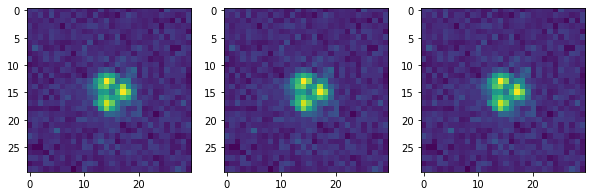

In [13]:
pdiv_ind = 0
zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, ax = plt.subplots(1,3,figsize=(10,10))
for ind in range(3):
    ax[ind].imshow(modelled_stack[...,zdiv_mid_ind-1,pdiv_ind])

# Tests

In [63]:
from scipy.special import jv 
from pyPSFstack.functions import colorize

In [26]:
params = {}
params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = distance_coverslip/wavelength
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = 2.5
params['pupil']['N_pts'] = 64

In [14]:
wavelength*magnification/(cam_pixel_size*nf)

5.320766190331407

In [31]:
src = DipoleInterfaceSource(**params['pupil'],**params['source'])

In [10]:
test = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psfs.psf_stack, axes=(0,1)), axes=(0,1)), axes=(0,1))

In [11]:
test.shape

(256, 256, 7, 2)

In [51]:
test_fft = np.fft.fft2(test[...,0,0], s=(src.N_pts,src.N_pts))
test_fft_pad = np.fft.fft2(np.pad(test[...,0,0], pad_width=[[0,11],]))

In [14]:
src.get_pupil_array().shape

(98, 98, 2, 3)

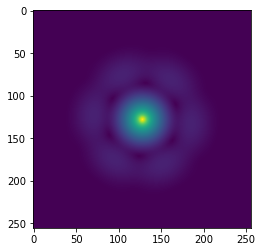

In [13]:
plt.imshow(np.abs((test[:,:,3,0])))

In [20]:
X,Y =np.meshgrid(np.arange(256),np.arange(256))
ap_otf = (X-255/2)**2 +(Y-255/2)**2 < (98)**2

In [17]:
ap_otf

array([], shape=(0, 0), dtype=bool)

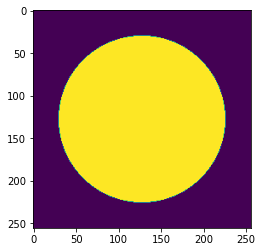

In [21]:
plt.imshow(ap_otf)

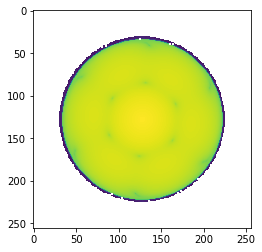

In [23]:
plt.imshow(np.log(np.abs(ap_otf*(test[:,:,3,0]))))

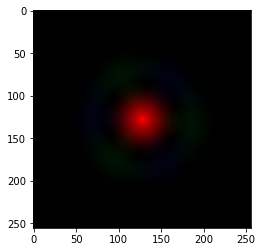

In [77]:
plt.imshow(colorize(test[:,:,3,0]))

In [46]:
plt.imshow(np.abs())

ValueError: invalid number of arguments

In [24]:
test = src.get_pupil_array()

In [43]:
from scipy.special import jv
def blurring_kernel(ur, radius, diff_del_list):
    ur = ur[...,None]
    rad_d = nf * (radius**2 - diff_del_list**2)**(1/2)
    bk = rad_d * jv(1, 2*np.pi*ur*rad_d) / ur
        
    return bk

In [39]:
ur, _ = src.polar_mesh(umax=2)

In [67]:
params['source']['delta']

0.01904761904761905

In [93]:
X,Y = np.meshgrid(np.arange(-1,1,1),np.arange(-1,1,1))
r = (X**2+Y**2)**(1/2)
ori = r==0

In [94]:
ori

array([[False, False],
       [False,  True]])

In [79]:
blurring_kernel(np.array([[0.]]), 0.02, np.arange(-0.02,0.02, 0.001))

array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan]]])

In [90]:
bk = blurring_kernel(r, 0.02, np.arange(-0.02,0.02, 0.001))

In [100]:
np.empty([2,2]+[1]*2).shape

(2, 2, 1, 1)

In [95]:
bk[ori,:]

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]])

In [92]:
bk[:,:,1]

array([[0.00028208, 0.00028221],
       [0.00028221,        nan]])

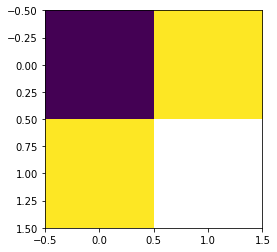

In [91]:
plt.imshow(bk[...,1])

In [35]:
params['source']['delta']

0.01904761904761905

In [33]:
np.expand_dims(test,
                list(np.arange(2,0,1))) .shape

(98, 98, 2, 3, 1, 1, 1)

In [37]:
np.expand_dims(test,
                [2,3,-1,-2]).shape

(98, 98, 1, 1, 2, 3, 1, 1)

In [32]:
list(np.arange(-3,0,1))

[-3, -2, -1]